In [1]:
pip install networkx matplotlib


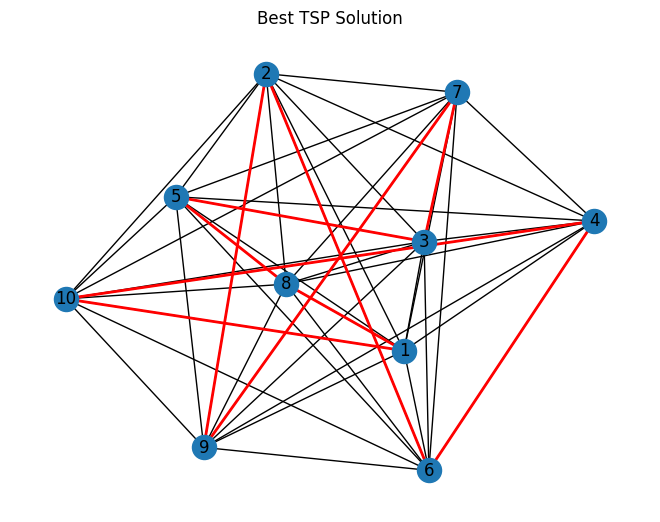

Best TSP solution cost: 42


In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def generate_tsp_graph(num_nodes):
    # Generate a random TSP graph using networkx
    G = nx.complete_graph(num_nodes)
    for i, j in G.edges():
        G[i][j]['weight'] = np.random.randint(1, 20)

    # Rename nodes to start from 1
    G = nx.relabel_nodes(G, {i: i + 1 for i in G.nodes()})

    return G


def load_tsp_data(file_path):
    # Load TSP data from a TSPLIB formatted file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    node_coord_section = False
    coordinates = {}

    for line in lines:
        if line.startswith('EOF'):
            break
        if node_coord_section:
            parts = line.strip().split()
            if len(parts) == 3:
                node, x, y = parts
                coordinates[int(node)] = (float(x), float(y))
        elif line.startswith('NODE_COORD_SECTION'):
            node_coord_section = True

    num_nodes = len(coordinates)
    G = nx.Graph()
    G.add_nodes_from(range(1, num_nodes + 1))

    for i in range(1, num_nodes + 1):
        for j in range(i + 1, num_nodes + 1):
            xi, yi = coordinates[i]
            xj, yj = coordinates[j]
            distance = np.sqrt((xi - xj)**2 + (yi - yj)**2)
            G.add_edge(i, j, weight=distance)

    return G

def plot_tsp_solution(G, solution, title="TSP Solution"):
    pos = nx.spring_layout(G)  # Layout for the visualization
    nx.draw(G, pos, with_labels=True)

    # Convert the solution path to an edgelist
    edges = [(solution[i], solution[i + 1]) for i in range(len(solution) - 1)]
    edges.append((solution[-1], solution[0]))  # Connect the last and first nodes
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='r', width=2)

    plt.title(title)
    plt.show()


def ant_colony(G, n_ants, n_best, n_iterations, decay, alpha=1, beta=2):
    pheromone = 1 / len(G.edges()) * np.ones((len(G.nodes()), len(G.nodes())))
    all_time_best = ("placeholder", np.inf)
    history = []

    for i in range(n_iterations):
        all_paths = []
        for ant in range(n_ants):
            path = generate_ant_path(G, pheromone, alpha, beta)
            all_paths.append((path, calculate_path_cost(G, path)))

        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        best_path = sorted_paths[0]

        if best_path[1] < all_time_best[1]:
            all_time_best = best_path

        pheromone = update_pheromone(G, pheromone, all_paths, n_best, decay)

        history.append(all_time_best)

    return all_time_best, history

def generate_ant_path(G, pheromone, alpha, beta):
    path = []
    visited = set()

    start = np.random.randint(1, len(G.nodes()) + 1)
    visited.add(start)
    path.append(start)

    while len(visited) < len(G.nodes()):
        options = get_neighbourhood(G, path[-1], visited)
        probabilities = calculate_probabilities(G, pheromone, path[-1], options, alpha, beta)

        next_node = np.random.choice(options, p=probabilities)
        path.append(next_node)
        visited.add(next_node)

    return path

def calculate_probabilities(G, pheromone, current_node, options, alpha, beta):
    pheromone_current = pheromone[current_node - 1]

    numerators = [pheromone_current[i - 1]**alpha * (1 / G[current_node][i]['weight'])**beta for i in options]
    denominator = sum(numerators)

    probabilities = [numerator / denominator for numerator in numerators]
    return probabilities

def get_neighbourhood(G, node, visited):
    return [neighbour for neighbour in G.neighbors(node) if neighbour not in visited]

def calculate_path_cost(G, path):
    cost = 0
    for i in range(len(path) - 1):
        cost += G[path[i]][path[i + 1]]['weight']
    return cost

def update_pheromone(G, pheromone, all_paths, n_best, decay):
    pheromone *= (1 - decay)

    for path, cost in all_paths[:n_best]:
        for i in range(len(path) - 1):
            pheromone[path[i] - 1][path[i + 1] - 1] += 1 / cost

    return pheromone

# Example usage with a random TSP graph
num_nodes = 10
G = generate_tsp_graph(num_nodes)

# Example usage with a TSPLIB dataset
# tsplib_file_path = 'path/to/your/tsp/file.tsp'
# G = load_tsp_data(tsplib_file_path)

# Ant Colony Optimization parameters
n_ants = 5
n_best = 2
n_iterations = 20
decay = 0.5

# Run Ant Colony Optimization
best_path, history = ant_colony(G, n_ants, n_best, n_iterations, decay)

# Plot the best solution
plot_tsp_solution(G, best_path[0], title="Best TSP Solution")

# Display the cost of the best solution
print("Best TSP solution cost:", best_path[1])
